In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()

color_pal = sns.color_palette()

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0

<AxesSubplot: title={'center': 'PJME Energy Use'}, xlabel='Datetime'>

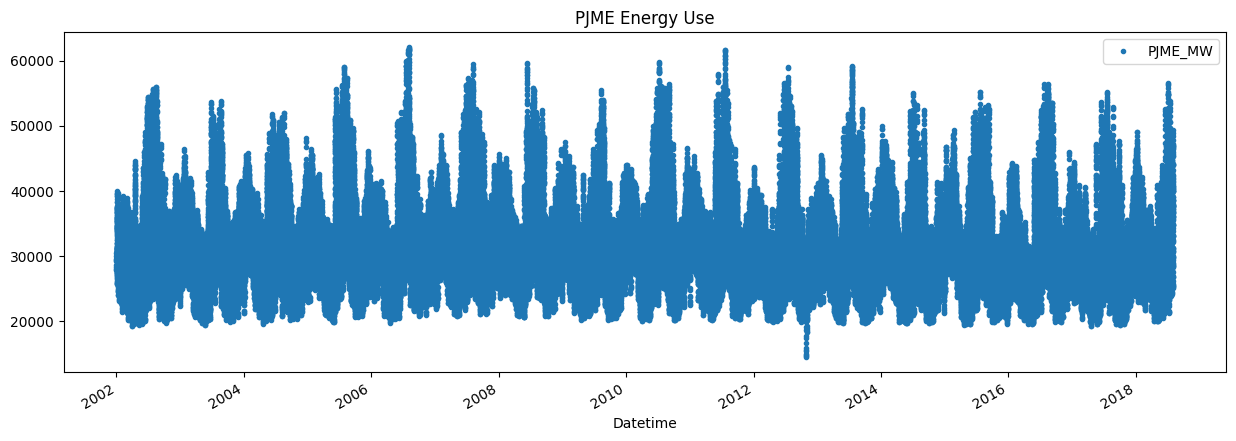

In [3]:
df.plot( style = '.', figsize = (15,5), color = color_pal[0], title = 'PJME Energy Use')

In [4]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# Train/Test Split

In [5]:
train = df[df.index < '2015-01-01']
test = df[df.index >= '2015-01-01']

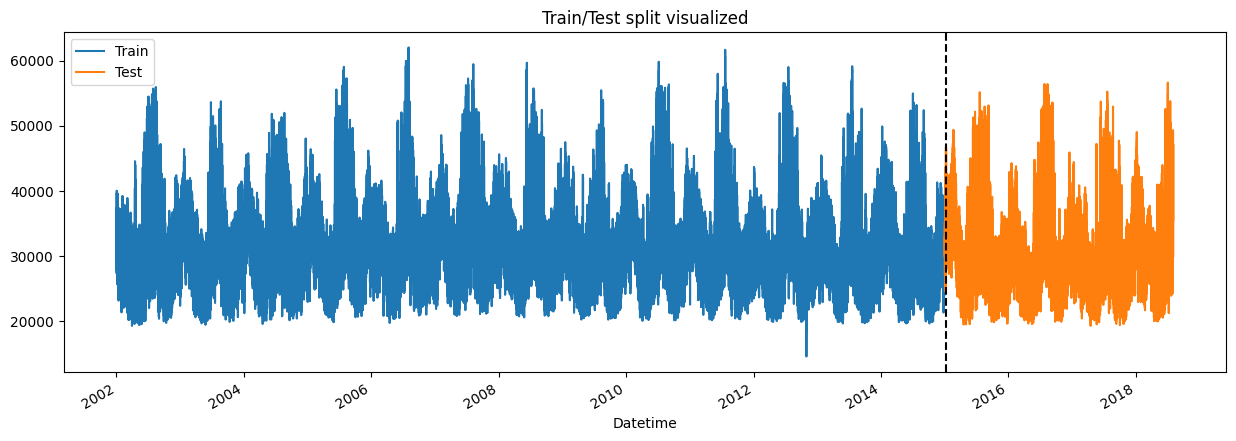

In [6]:
fig, ax = plt.subplots( figsize = (15,5))

train.plot(ax = ax, label = 'train', title = 'Train/Test split visualized')
test.plot(ax = ax, label = 'test')
ax.axvline('2015-01-10', color = 'black', ls = '--')
ax.legend(['Train','Test'])
plt.show()

# EDA

<AxesSubplot: title={'center': 'OneWeek sample data'}, xlabel='Datetime'>

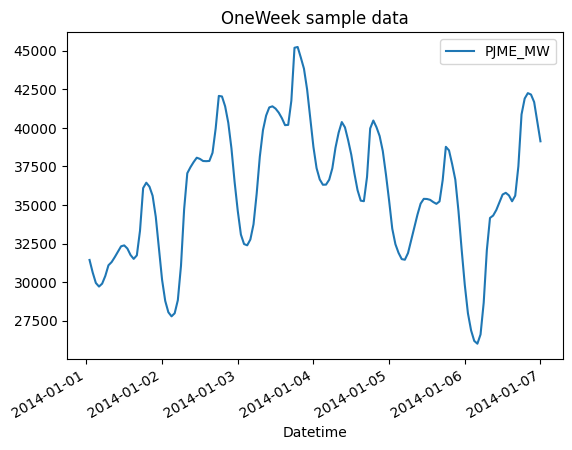

In [7]:
oneweek = df.loc[(df.index > '2014-01-01') & (df.index <= '2014-01-07')]
oneweek.plot(title = 'OneWeek sample data')

In [8]:
# daily fluctuation
# weekned effect

## Feature creation

In [9]:
def create_time_features(df):
    """
    Create extra time series features using the index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    df['date'] = df.index.date.astype('datetime64')
    df['holiday'] = (df['date'].dt.date.astype('datetime64').isin(cal.holidays())).astype(int)
    del df['date']
    
    return df

In [10]:
df = create_time_features(df)

## Visualize Features

Text(0.5, 1.0, 'MW per hour')

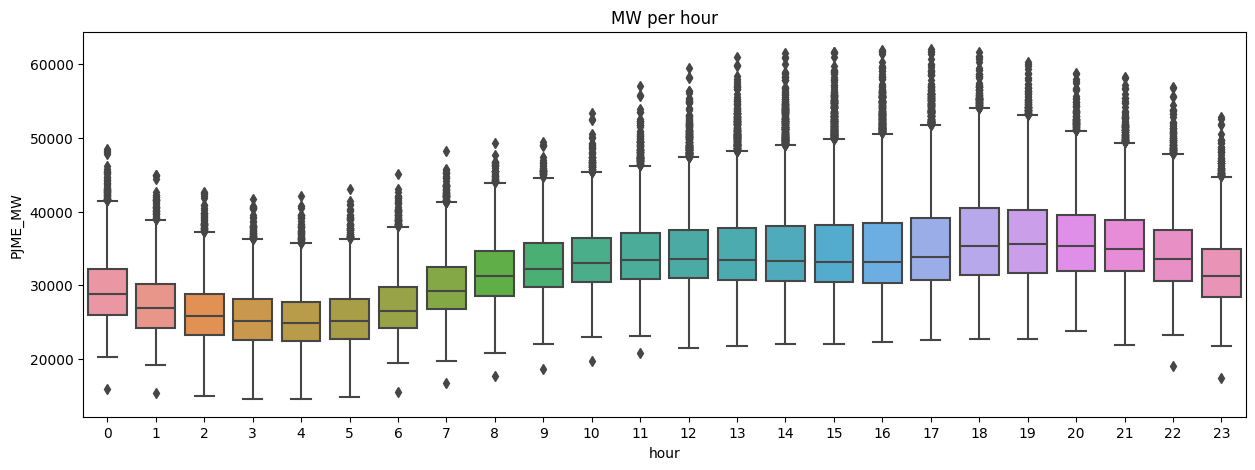

In [11]:
fig,ax = plt.subplots(figsize = (15,5))

sns.boxplot(data = df, x='hour', y='PJME_MW')
ax.set_title('MW per hour')

Text(0.5, 1.0, 'MW per hour')

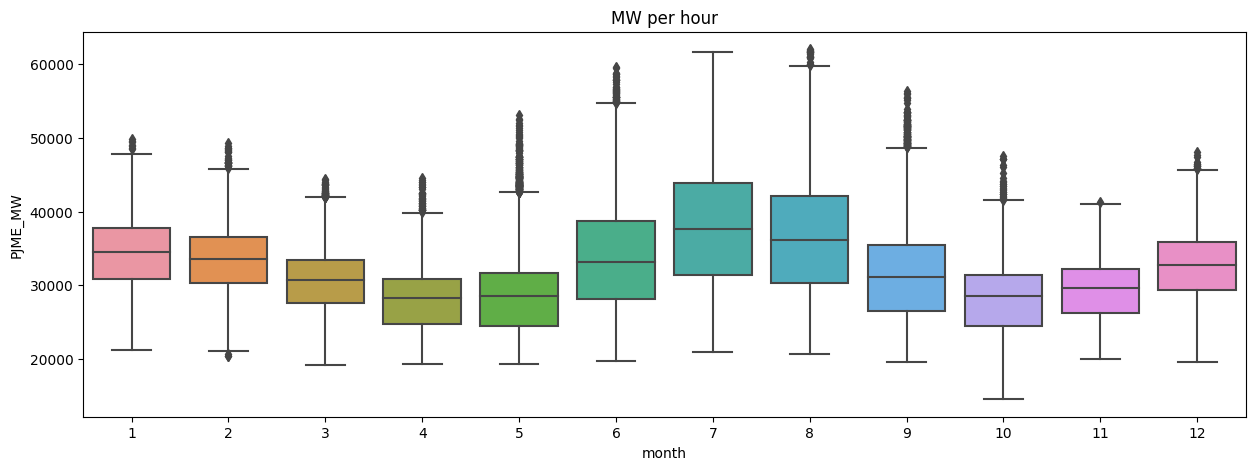

In [12]:
fig,ax = plt.subplots(figsize = (15,5))

sns.boxplot(data = df, x='month', y='PJME_MW')
ax.set_title('MW per hour')

## Outlier removal

In [13]:
def daily_IQR(df):
    
    df = df.copy()

    df['date'] = df.index.date
    avg_df = pd.DataFrame(data = df.groupby('date')['PJME_MW'].mean())
    avg_df.columns = ['daily_avg_MW']
    avg_df['daily_avg_MW'] = avg_df['daily_avg_MW'].astype(int)
    
    Q1 = avg_df.quantile(0.25)['daily_avg_MW']
    Q3 = avg_df.quantile(0.75)['daily_avg_MW']
    IQR = Q3 - Q1
    
    lower_bond = Q1 - 1.4 * IQR
    upper_bond = Q3 + 1.4 * IQR
    
    df = df.merge(avg_df[['daily_avg_MW']], how = 'left', left_on= 'date', right_index=True)
    df_masked = df[(df['daily_avg_MW'] >= lower_bond) & (df['daily_avg_MW'] <= upper_bond)]

    return df_masked

In [14]:
df2 = daily_IQR(df)
df2.head()

PJME_MW  hour  dayofweek  month  quarter  year  \
Datetime                                                              
2002-12-31 01:00:00  26498.0     1          1     12        4  2002   
2002-12-31 02:00:00  25147.0     2          1     12        4  2002   
2002-12-31 03:00:00  24574.0     3          1     12        4  2002   
2002-12-31 04:00:00  24393.0     4          1     12        4  2002   
2002-12-31 05:00:00  24860.0     5          1     12        4  2002   

                     dayofyear  holiday        date  daily_avg_MW  
Datetime                                                           
2002-12-31 01:00:00        365        0  2002-12-31         29560  
2002-12-31 02:00:00        365        0  2002-12-31         29560  
2002-12-31 03:00:00        365        0  2002-12-31         29560  
2002-12-31 04:00:00        365        0  2002-12-31         29560  
2002-12-31 05:00:00        365        0  2002-12-31         29560

# Modelling

In [15]:
train = create_time_features(train)
train = daily_IQR(train)
test = create_time_features(test)

In [22]:
features = ['hour', 'dayofweek', 'month', 'quarter', 'year','dayofyear','holiday']
target = ['PJME_MW']

In [23]:
X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [24]:
model = xgb.XGBRegressor(n_estimators = 800, learning_rate = 0.005, max_depth=5)
model.fit(X_train,
          y_train,
          eval_set =[(X_train,y_train), (X_test,y_test)],
          verbose = 50)

[0]	validation_0-rmse:32450.71892	validation_1-rmse:31817.92758
[50]	validation_0-rmse:25355.66923	validation_1-rmse:24715.85958
[100]	validation_0-rmse:19855.00052	validation_1-rmse:19227.91614
[150]	validation_0-rmse:15597.23779	validation_1-rmse:14975.81728
[200]	validation_0-rmse:12315.75274	validation_1-rmse:11730.54265
[250]	validation_0-rmse:9793.38716	validation_1-rmse:9278.42415
[300]	validation_0-rmse:7876.40321	validation_1-rmse:7457.55480
[350]	validation_0-rmse:6431.38946	validation_1-rmse:6163.21340
[400]	validation_0-rmse:5357.47799	validation_1-rmse:5251.87526
[450]	validation_0-rmse:4573.20285	validation_1-rmse:4644.08467
[500]	validation_0-rmse:4010.95443	validation_1-rmse:4249.69046
[550]	validation_0-rmse:3617.69411	validation_1-rmse:4004.81025
[600]	validation_0-rmse:3346.65026	validation_1-rmse:3858.07317
[650]	validation_0-rmse:3155.99317	validation_1-rmse:3769.26435
[700]	validation_0-rmse:3021.40044	validation_1-rmse:3718.24665
[750]	validation_0-rmse:2928.3143

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=800, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [25]:
dict(zip(model.feature_importances_,features))

{0.40136227: 'hour',
 0.16117232: 'dayofweek',
 0.27706316: 'month',
 0.0: 'quarter',
 0.018948486: 'year',
 0.10105291: 'dayofyear',
 0.040400863: 'holiday'}

In [26]:
fi = pd.DataFrame( data = model.feature_importances_,
                   index = features,
                   columns = ['importance_score'])

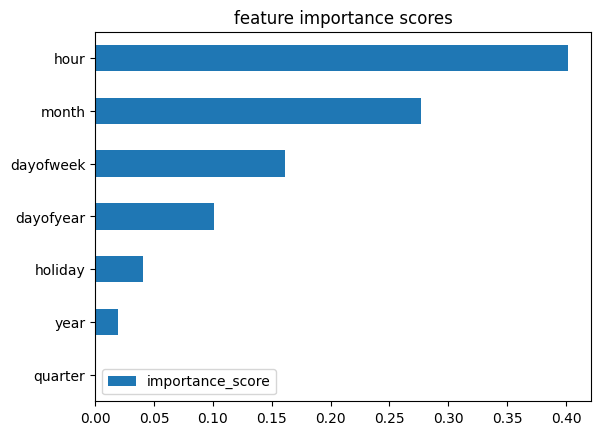

In [27]:
fi.sort_values('importance_score').plot(kind = 'barh', title = 'feature importance scores')
plt.show()

# Forcasting

In [28]:
test['prediction'] = model.predict(X_test)

In [29]:
df = df.merge(test[['prediction']], 'left', left_index=True, right_index=True)

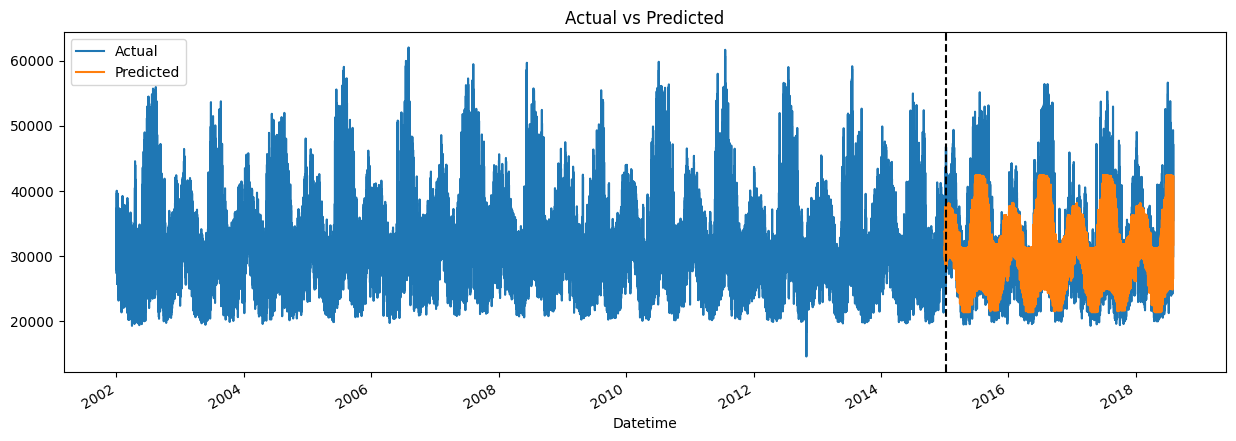

In [30]:
fig, ax = plt.subplots( figsize = (15,5))

df[['PJME_MW']].plot(ax = ax, title = 'Actual vs Predicted')
df[['prediction']].plot(ax = ax)
ax.axvline('2015-01-10', color = 'black', ls = '--')
ax.legend(['Actual','Predicted'])
plt.show()

<AxesSubplot: title={'center': 'OneWeek sample data'}, xlabel='Datetime'>

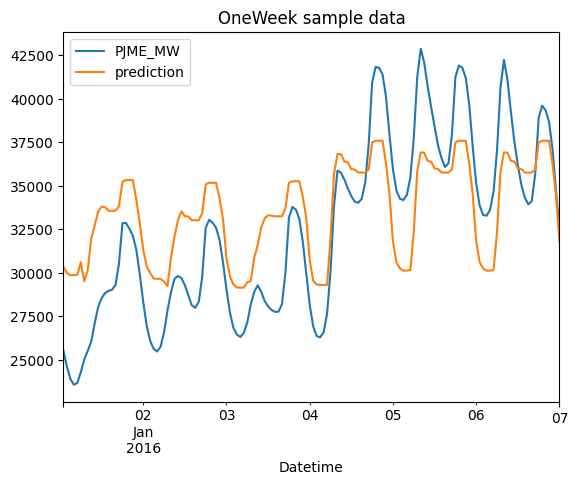

In [31]:
oneweek = df.loc[(df.index > '2016-01-01') & (df.index <= '2016-01-07')]
oneweek[['PJME_MW','prediction']].plot(title = 'OneWeek sample data')

In [32]:
score = np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3691.35


# Calculate Error

In [33]:
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])

In [34]:
test['date'] = test.index.date

In [35]:
test.groupby("date")['error'].mean().sort_values( ascending = False).head(5)

date
2016-08-13    13263.324463
2016-08-14    13051.594808
2016-09-10    12608.405273
2016-09-09    11315.372559
2015-02-20    11060.058431
Name: error, dtype: float64